In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
from diff_gaussian_rasterization import rasterize, rasterize_jit
import matplotlib.pyplot as plt

In [37]:
key = jax.random.PRNGKey(3)

def render_with_param_transform( means3D, colors_precomp, opacity, scales, rotations,
           image_width, image_height, fx,fy, cx,cy,near,far):
    color = rasterize(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return color


def loss( means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far, color_gt):
    color = render_with_param_transform(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return jnp.sum(0.5 * (color[:3] - color_gt[:3])**2)

loss_grad = jax.jit(jax.value_and_grad(loss, argnums=(0,1,2,3,4,)), static_argnums=(5,6,7,8,9,10,11,12,))

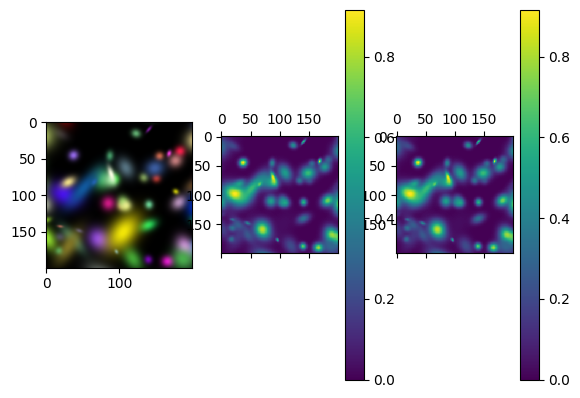

In [40]:
image_width, image_height, fx, fy, cx, cy, near, far = 200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5

N = 100
key = jax.random.split(key, 2)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1)) * 1.0
scales =jnp.ones((N,3)) * 4e-2
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color_gt = render_with_param_transform(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(jnp.transpose(color_gt[:3,...], (1,2,0)))
im = ax2.matshow(color_gt[3,...])
fig.colorbar(im, ax=ax2)
im = ax3.matshow(color_gt[4,...])
fig.colorbar(im, ax=ax3)

# fig.colorbar(im, cax=ax3, orientation='vertical')


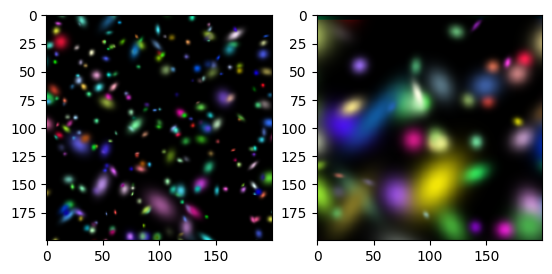

In [61]:
N = 500
key = jax.random.split(key, 1)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1)) * 1.0
scales =jnp.ones((N,3)) * 1e-2
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color = render_with_param_transform(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

100%|██████████| 1000/1000 [00:01<00:00, 508.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


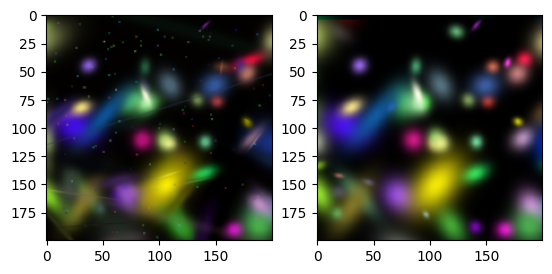

In [66]:
import optax

# params = (means3D, colors_precomp, opacity, scales, rotations)
# param_labels = ("means3D", "colors_precomp", "opacity", "scales", "rotations")
# tx = optax.multi_transform(
#     {
#         'means3D': optax.sgd(0.00001),
#         'colors_precomp': optax.sgd(0.0004),
#         'opacity': optax.sgd(0.0),
#         'scales': optax.sgd(0.0001),
#         'rotations': optax.sgd(0.00001),
#     },
#     param_labels
# )
# state = tx.init(params)

from tqdm import tqdm

for _ in tqdm(range(1000)):
    loss,(dL_dmeans3D, dL_dcolors, dL_dopacity, dL_dscales, dL_drotations) = loss_grad(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far, color_gt
    )

    # updates, new_state = tx.update(gradients, state, params)
    # params = optax.apply_updates(params, updates)
    # means3D, colors_precomp, opacity, scales, rotations = [a+b for a,b in zip(params, gradients)]
    params = (means3D, colors_precomp, opacity, scales, rotations)
    color = rasterize_jit(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )

    means3D = means3D - dL_dmeans3D  * 0.00001
    colors_precomp = colors_precomp - dL_dcolors[:,:3]  * 0.0001
    scales = scales - dL_dscales  * 0.001
    rotations = rotations - dL_drotations  * 0.0001
    opacity = opacity - dL_dopacity  * 0.00001

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

In [49]:
for i in (dL_dmeans3D, dL_dcolors, dL_dopacity, dL_dscales, dL_drotations):
    print(i.max())

1623.9447
568.0372
725.157
3319.4941
372.4254


In [34]:
dL_drotations

Array([[-0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-3.0493399e-02, -4.2889040e-02, -5.9972703e-03, -1.7740371e-02],
       [ 1.2542481e-05, -2.1382648e-06,  1.7884394e-04, -4.2101314e-05],
       [ 6.9988594e+04,  5.5961230e+04,  6.5621883e+04, -4.6978203e+04]],      dtype=float32)

In [8]:
params[0]

Array([[-0.39708006, -0.03343368,  0.6174457 ],
       [-0.4853214 ,  0.22863507,  0.7452736 ],
       [ 0.02821374,  0.3770131 ,  1.0830323 ],
       ...,
       [-0.3934232 ,  0.4675852 ,  1.1835682 ],
       [ 0.16981304,  0.3270017 ,  0.64350903],
       [ 0.23123145,  0.41174412,  1.3416651 ]], dtype=float32)